In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from backbone_xception import Xception_model
from add_output_layers import add_output_layers
from tensorflow.keras import Input, Model
from loss_function import *
import numpy as np
import data_processing_val as dp
import os, argparse, time, pickle
from pathlib2 import Path

import visualization
import random
import matplotlib.pyplot as plt
# from loss_function import loss_func
# dp.tricosine_to_alpha_rad()
# dp.sector2angle()
# dp.KittiGenerator()

### Reading in Predictions and Ground Truths on Validation Set

In [2]:
# split = 0.1
# #Load all ground truth annotations
# with open ("inputs/train_data.json", "r") as data:
#     annos = json.load(data)
#     #Use only the validation annotations
#     val_annos = annos[round(len(annos)*(1-split)):]

# with open ("val_output/radian_predictions.json", "r") as pred_file:
#     val_preds = json.load(pred_file)
#     val_preds = val_preds[0]
# with open ("val_output/dimout.json", "r") as pred_file:
#     dim_preds = json.load(pred_file)
#     dim_preds = dim_preds[0]

### Utility Functions for Visualization

In [3]:
# #Generates a filler label for angle visualization from an annotation
# def kit_lbl_from_anno(annotation,danno=None):
#     final_str = ""
#     final_str += "Car "
#     final_str += "0.0 0 0.00 "
#     ry = annotation['ry']
#     dims = annotation['dimensions']
#     loc = annotation['location']
#     bbox = annotation['bbox']
#     final_str += str(bbox[0]) + " " + str(bbox[1]) + " " + str(bbox[2]) + " " + str(bbox[3]) + " "
#     final_str += str(dims[0]) + " " + str(dims[1]) + " " + str(dims[2]) + " "
#     final_str += str(loc[0]) + " " + str(loc[1]) + " " + str(loc[2]) + " "
#     final_str += str(ry)
#     return final_str
    

# #Generate a label for an angle based on ground truth and predicted ry
# def gen_pred_label(gt_label, pred_angle):
#     final_str = ""
#     gt_tokens = gt_label.split(" ")
#     for i in range(0, 14):
#         final_str += str(gt_tokens[i]) + " "
#     final_str += str(pred_angle)

# #Reads in the appropriate image and provides a path to the calibration file
# def get_image_and_calib_path(annotation):
#     im_id = annotation['image_id']
#     img_name = str(im_id).zfill(6)
#     img = plt.imread(os.path.join('../../home/ubuntu/kitti-3d-detection-unzipped/training/image_2/', img_name + ".png"))
#     return img, os.path.join("../../home/ubuntu/kitti-3d-detection-unzipped/training/calib/", img_name + ".txt")

### Selected Example Results and Visualizations

In [4]:
os.listdir("./dataset/training/")

['image_2', 'label_2', 'calib']

In [6]:
NUM_SECTOR = 8
NUM_BIN = 2
BATCH_SIZE = 4
# DATASET_SIZE = ???
NUM_WORKERS = 1
data_label = './dataset/training/label_2/'
data_img = './dataset/training/image_2/'

orientation = 'alpha_sector'

print('Loading generator')
generator = dp.KittiGenerator(label_dir= data_label, 
                              image_dir= data_img,
                              mode = 'val',
                              sectors = NUM_SECTOR, 
                              batch_size = BATCH_SIZE,
                              orientation_type = orientation )


  9%|██████████                                                                                                  | 700/7481 [00:00<00:00, 6949.29it/s]

Loading generator


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7481/7481 [00:01<00:00, 6913.37it/s]


In [7]:
num_epochs = 60

sect_add = "_{}".format(NUM_SECTOR) if orientation == 'alpha_sector' else ""
weights_path = "./weights/{o}{sect}/{o}_model.{e}.h5".format(o=orientation,
                                                             e=num_epochs,
                                                             sect=sect_add)
inputs = Input(shape=(224, 224, 3))
x = Xception_model(inputs, pooling='avg')
x = add_output_layers(orientation, x, NUM_SECTOR,NUM_BIN)
model = Model(inputs=inputs, outputs=x)
model.compile(loss=loss_func(orientation), optimizer='adam')
model.load_weights(weights_path)

gen_output = generator[0]

pred = model.predict(x=gen_output[:2],
                     verbose=1,
                     workers=NUM_WORKERS)

# pred = model.predict(x=generator,
#                      verbose=1,
#                      workers=NUM_WORKERS)

# if orientation_type == 'tricosine': pred = tricosine_to_alpha_rad(pred)
# if orientation_type == 'alpha_sectors': pred = cat2angle(pred)
    
# I need the 
# -> (x,y,z) position of the vehicle   -> 
# -> the original image name           -> convert lpha to rot_y

4/4 [==============================] - 1s 357ms/sample


In [8]:
pred

array([[-1063.4651 ,   898.7967 ,   918.0069 ,  -936.11914,   859.5089 ,
          769.5337 ,  -752.3185 ,  -862.23016],
       [ -971.1575 ,   851.7103 ,   877.0151 ,  -895.1622 ,   795.80347,
          715.2575 ,  -692.81177,  -833.57965],
       [ -824.978  ,   738.5231 ,   732.10364,  -771.1586 ,   678.2485 ,
          615.04755,  -596.1741 ,  -693.92664],
       [-1318.5343 ,  1114.6592 ,  1109.4387 , -1150.3268 ,  1071.2058 ,
          956.7781 ,  -940.37756, -1037.4448 ]], dtype=float32)

In [176]:
objs = generator.all_objs
objs[gen_output[0][2]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [9]:
os.listdir("./dataset/training/")

['image_2', 'label_2', 'calib']

gt_label Car 0.00 0 -1.83 641.42 179.82 769.98 264.01 1.39 1.54 3.42 1.65 1.53 13.83 -1.72

alpha_sector prediction: [-1063.4651    898.7967    918.0069   -936.11914   859.5089    769.5337
  -752.3185   -862.23016]
alpha,roty_pred,loc,np.arctan(x/z):  1.9634954084936207 2.0822399904314106 [ 1.65  1.53 13.83] 0.11874458

pred roty: 2.0822399904314106
gt roty: -1.72
distance: 0.36223999043141064

pred alpha: 1.9634954084936207
gt alpha: -1.83
distance: 0.13349540849362063

TESTING alpha2roty(), with gt angles. alpha2roty(gt_alpha)=-1.7112554180622102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


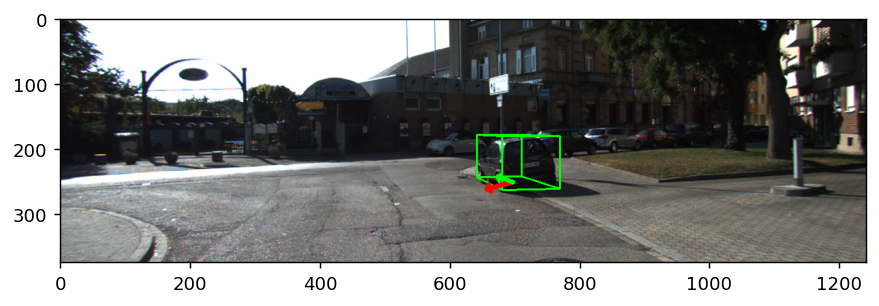

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------------------------------------




gt_label Van 0.00 0 1.42 1023.06 140.07 1093.47 200.11 2.75 2.04 6.05 22.33 1.28 36.21 1.97

alpha_sector prediction: [-971.1575   851.7103   877.0151  -895.1622   795.80347  715.2575
 -692.81177 -833.57965]
alpha,roty_pred,loc,np.arctan(x/z):  1.9634954084936207 2.5160897721830433 [22.33  1.28 36.21] 0.55259436

pred roty: 2.5160897721830433
gt roty: 1.97
distance: 0.5460897721830433

pred alpha: 1.9634954084936207
gt alpha: 1.42
distance: 0.5434954084936208

TESTING alpha2roty(), with gt angles. alpha2roty(gt_alpha)=1.9725943636894225


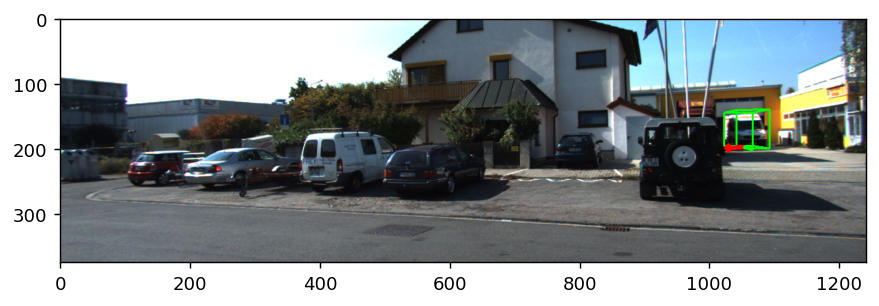

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------------------------------------




gt_label Car 0.00 0 -1.58 583.86 180.52 600.08 193.37 1.26 1.60 3.56 -1.85 2.05 73.31 -1.60

alpha_sector prediction: [-824.978    738.5231   732.10364 -771.1586   678.2485   615.04755
 -596.1741  -693.92664]
alpha,roty_pred,loc,np.arctan(x/z):  1.1780972450961724 1.1528672974546805 [-1.85  2.05 73.31] -0.025229948

pred roty: 1.1528672974546805
gt roty: -1.6
distance: 0.44713270254531956

pred alpha: 1.1780972450961724
gt alpha: -1.58
distance: 0.40190275490382765

TESTING alpha2roty(), with gt angles. alpha2roty(gt_alpha)=-1.605229947641492


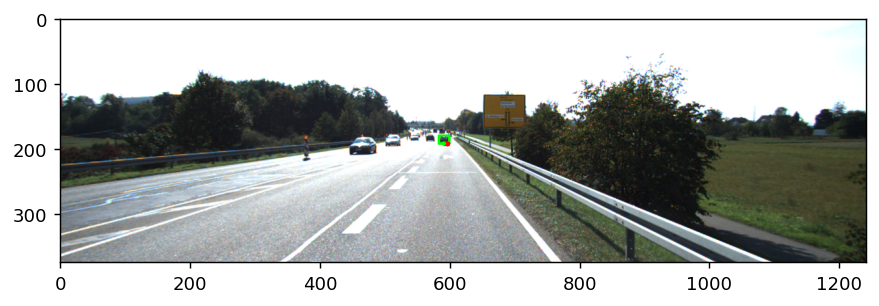

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------------------------------------




gt_label Pedestrian 0.00 0 -1.88 822.41 176.05 881.55 322.88 1.63 0.71 0.88 2.88 1.57 8.44 -1.57

alpha_sector prediction: [-1318.5343   1114.6592   1109.4387  -1150.3268   1071.2058    956.7781
  -940.37756 -1037.4448 ]
alpha,roty_pred,loc,np.arctan(x/z):  1.1780972450961724 1.5069399148215905 [2.88 1.57 8.44] 0.32884267

pred roty: 1.5069399148215905
gt roty: -1.57
distance: 0.06306008517840955

pred alpha: 1.1780972450961724
gt alpha: -1.88
distance: 0.7019027549038275

TESTING alpha2roty(), with gt angles. alpha2roty(gt_alpha)=-1.5511573302745818


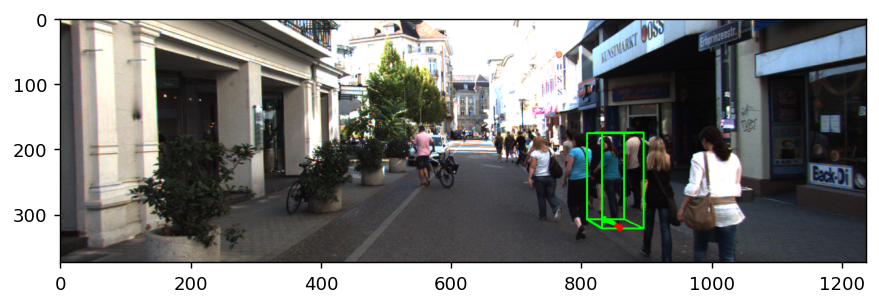

--------------------------------------------------------------------------------------------------------------






In [11]:
root_img_path = "./dataset/training/image_2/"
root_calib_path = "./dataset/training/calib/"
objs = generator.all_objs

num_batches = 1

#Some examples of visualizations
for j in range(num_batches):
    for i,ob in enumerate(generator[j][2]):
        #i = random.randint(0, len(val_annos)) #Uncomment this line for random samples of the validation set
        single_obj = objs[ob]
        img_name = str(single_obj['image_path']).split(".")[0]
        img_path = os.path.join(root_img_path, img_name + ".png")
        calib_path = os.path.join(root_calib_path, img_name + ".txt")
        disp_img = plt.imread(img_path)

        gt_label = single_obj['kitti_label']
        loc = gt_label.split(" ")[11:14]
        loc = np.asarray(loc,dtype=np.float32)
        x,y,z = loc
        
        if orientation == 'tricosine':
            assert(max(pred[i]) < 1.1 and min(pred[i]) > -1.1) # make sure the model is JUST rounding a bit off
            if max(pred[i]) > 1.0:    pred[i] = pred[i]/max(pred[i])
            elif min(pred[i]) < -1.0: pred[i] = pred[i]/(-min(pred[i]))
                
            print("pre_tricosine", pred[i])
            alpha = dp.tricosine_to_alpha_rad(pred[i])
            rot_y_pred = alpha2roty(alpha,loc)
        
        if orientation == 'alpha':
            alpha = pred[i][0]%(2*np.pi)
            rot_y_pred = alpha2roty(alpha,loc)
            
            
        if orientation == 'alpha_sector':
            alpha = dp.sector2angle(pred[i],NUM_SECTOR)
            alpha = alpha%(2*np.pi)
            rot_y_pred = alpha2roty(alpha,loc)


        print("gt_label",gt_label)
        # print(gt_label.split(" ")[14])
        print(orientation,"prediction:",pred[i])
        print("alpha,roty_pred,loc,np.arctan(x/z): ",alpha,rot_y_pred,loc,np.arctan(x/z))
        print()
        
        gt_rot_y = float(gt_label.split(" ")[14])
        gt_alpha = float(gt_label.split(" ")[3])
        
        alpha_distance = min(abs(alpha + gt_alpha),abs(alpha - gt_alpha))
        roty_distance = min(abs(rot_y_pred + gt_rot_y),abs(rot_y_pred - gt_rot_y))
        
        print("pred roty:", rot_y_pred)
        print("gt roty:", gt_rot_y)
        print("distance:", roty_distance)
        print()
        print("pred alpha:", alpha)
        print("gt alpha:", gt_alpha)
        print("distance:", alpha_distance)
        print()
        print("TESTING alpha2roty(), with gt angles. alpha2roty(gt_alpha)="+str(alpha2roty(gt_alpha,loc)))
        
        
        viz = visualization.make_arrow(calib_path, 
                                       gt_label, 
                                       disp_img, 
                                       rot_y_pred)

        plt.figure(num=None, figsize=(8, 6), dpi=130, facecolor='w', edgecolor='k')
        plt.imshow(viz)
        plt.show()
        
        print("--------------------------------------------------------------------------------------------------------------")
        print();print();print();print()

In [12]:
# #Some examples of visualizations
# for i in [1830, 2631, 900, 850, 466, 1586]:
#     #i = random.randint(0, len(val_annos)) #Uncomment this line for random samples of the validation set
#     gt_label = kit_lbl_from_anno(val_annos[i])
#     #gen_pred_label(gt_label, val_preds[str(val_annos[i]['id'])])
#     disp_img, calib_path = get_image_and_calib_path(val_annos[i])
#     viz = visualization.make_arrow(calib_path, gt_label, disp_img, val_preds[str(val_annos[i]['id'])],dim_preds[str(val_annos[i]['id'])])
#     plt.figure(num=None, figsize=(8, 6), dpi=130, facecolor='w', edgecolor='k')
#     plt.imshow(viz)
#     plt.show()

In [ ]:
# #Some examples of visualizations
# for i in range(100):
#     i = random.randint(0, len(val_annos)) #Uncomment this line for random samples of the validation set
#     gt_label = kit_lbl_from_anno(val_annos[i],dim_preds)
#     gen_pred_label(gt_label, val_preds[str(val_annos[i]['id'])])
#     disp_img, calib_path = get_image_and_calib_path(val_annos[i])
#     try:
#         dp = dim_preds[str(val_annos[i]['id'])]
#     except KeyError:
#         print("bad iputs")
#         dp = None
#     viz = visualization.make_arrow(calib_path, gt_label, disp_img, val_preds[str(val_annos[i]['id'])],dp)
#     plt.figure(num=None, figsize=(8, 6), dpi=130, facecolor='w', edgecolor='k')
#     plt.imshow(viz)
#     plt.show()